# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
from collections import namedtuple, deque
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/nuno/workspaces/drlnd/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Environment and helper methods

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model: PyTorch model (weights will be copied from)
        target_model: PyTorch model (weights will be copied to)
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    pass


def hard_update(target, source):
    """Hard update model parameters.
    """
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(source_param.data)

    pass
       

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

def seeding(seed=10):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


### 4. DDPG Agent
Based on the ddpg-bipedal code provided in the [github repository](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal). Instead of using the OUNoise class, I have added some dropout layers to the actor and critic networks. I did not have time to compare each other, but it seems to work in a similar way.

In [6]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, full_state_size, full_action_size, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of both agents states
            action_size (int): Dimension of both agents actions
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+full_action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, full_state, full_action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(full_state))
        x = torch.cat((xs, full_action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)



class DDPG(object):
    """Interacts with and learns from the environment.
    There are two agents and the observations of each agent has 24 dimensions. Each agent's action has 2 dimensions.
    Will use two separate actor networks (one for each agent using each agent's observations only and output that agent's action).
    The critic for each agents gets to see the actions and observations of all agents. """
    
    def __init__(self, state_size, action_size, num_agents):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state for each agent
            action_size (int): dimension of each action for each agent
        """
        self.state_size = state_size
        self.action_size = action_size        

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(DEVICE)
        self.actor_target = Actor(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_target = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        self.noise = OUNoise(action_size) #single agent only
        self.noise_scale = NOISE_START
    
        # Make sure target is initialized with the same weight as the source (makes a big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def act(self, states, i_episode, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        if i_episode > EPISODES_BEFORE_TRAINING and self.noise_scale > NOISE_END:
            #self.noise_scale *= NOISE_REDUCTION
            self.noise_scale = NOISE_REDUCTION**(i_episode-EPISODES_BEFORE_TRAINING)
        #else keep the previous value
        
        if not add_noise:
            self.noise_scale = 0.0
                                    
        states = torch.from_numpy(states).float().to(DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise
        actions += self.noise_scale*self.add_noise2() #works much better than OU Noise process
        #actions += self.noise_scale*self.noise.sample()
        
        return np.clip(actions, -1, 1)

    def add_noise2(self):
        noise = 0.5*np.random.randn(1,self.action_size) #sigma of 0.5 as sigma of 1 will have alot of actions just clipped
        return noise
        
        
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        #for MADDPG
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, full_next_states, critic_full_next_actions = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get Q values from target models
        Q_target_next = self.critic_target(full_next_states, critic_full_next_actions)
        # Compute Q targets for current states (y_i)
        Q_target = agent_rewards + gamma * Q_target_next * (1 - agent_dones)
        # Compute critic loss
        Q_expected = self.critic_local(full_states, full_actions)
        critic_loss = F.mse_loss(input=Q_expected, target=Q_target) #target=Q_targets.detach() #not necessary to detach
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actor_loss = -self.critic_local.forward(full_states, actor_full_actions).mean() #-ve b'cse we want to do gradient ascent
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                  

        
        
    def soft_update_all(self):
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)


   
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)            


### 5. MADDPG
MADDPG agent

In [7]:
class MADDPG(object):
    '''The main class that defines and trains all the agents'''
    def __init__(self, state_size, action_size, num_agents):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.whole_action_dim = self.action_size*self.num_agents
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE) # Replay memory
        self.maddpg_agents = [DDPG(state_size, action_size, num_agents), DDPG(state_size, action_size, num_agents)] #create agents
        self.episodes_before_training = EPISODES_BEFORE_TRAINING
        
    def reset(self):
        for agent in self.maddpg_agents:
            agent.reset()

    def step(self, i_episode, states, actions, rewards, next_states, dones):
        #for stepping maddpg
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # index 0 is for agent 0 and index 1 is for agent 1
        full_states = np.reshape(states, newshape=(-1))
        full_next_states = np.reshape(next_states, newshape=(-1))
        
        # Save experience / reward
        self.memory.add(full_states, states, actions, rewards, full_next_states, next_states, dones)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and i_episode > self.episodes_before_training:
            for _ in range(NUM_LEARN_STEPS_PER_ENV_STEP): #learn multiple times at every step
                for agent_no in range(self.num_agents):
                    samples = self.memory.sample()
                    self.learn(samples, agent_no, GAMMA)
                self.soft_update_all()

    def soft_update_all(self):
        #soft update all the agents            
        for agent in self.maddpg_agents:
            agent.soft_update_all()
    
    def learn(self, samples, agent_no, gamma):
        #for learning MADDPG
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        critic_full_next_actions = torch.zeros(states.shape[:2] + (self.action_size,), dtype=torch.float, device=DEVICE)
        for agent_id, agent in enumerate(self.maddpg_agents):
            agent_next_state = next_states[:,agent_id,:]
            critic_full_next_actions[:,agent_id,:] = agent.actor_target.forward(agent_next_state)
        critic_full_next_actions = critic_full_next_actions.view(-1, self.whole_action_dim)
        
        agent = self.maddpg_agents[agent_no]
        agent_state = states[:,agent_no,:]
        actor_full_actions = actions.clone() #create a deep copy
        actor_full_actions[:,agent_no,:] = agent.actor_local.forward(agent_state)
        actor_full_actions = actor_full_actions.view(-1, self.whole_action_dim)
                
        full_actions = actions.view(-1,self.whole_action_dim)
        
        agent_rewards = rewards[:,agent_no].view(-1,1) #gives wrong result without doing this
        agent_dones = dones[:,agent_no].view(-1,1) #gives wrong result without doing this
        experiences = (full_states, actor_full_actions, full_actions, agent_rewards, \
                       agent_dones, full_next_states, critic_full_next_actions)
        agent.learn(experiences, gamma)

        #params_delete = list(agent.actor_local.parameters())
        #print(len(params_delete))
        #print(params_delete[2].size())
        #print(params_delete[0][0:3,0:3])
        

    def learn_double_ddpg(self, samples, agent_no, gamma):
        #for learning double ddpg (for debug only, do not use this)
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        temp_agent_no = np.random.randint(0,2) #to decide which agent's experience to use
        strt = temp_agent_no * self.state_size
        stp = strt + self.state_size
        full_states = full_states[:, strt:stp]
        states = states[:,temp_agent_no]
        actions = actions[:,temp_agent_no]
        rewards = rewards[:,temp_agent_no]
        full_next_states = full_next_states[:,strt:stp]
        next_states = next_states[:,temp_agent_no]
        dones = dones[:,temp_agent_no]
        
        
        agent = self.maddpg_agents[agent_no]
        critic_full_next_actions = agent.actor_target.forward(next_states)
        actor_full_actions = agent.actor_local.forward(states)
        full_actions = actions
        
        experiences = (full_states, actor_full_actions, full_actions, rewards, \
                        dones, full_next_states, critic_full_next_actions)
        
        agent.learn(experiences, gamma)

            
    def act(self, full_states, i_episode, add_noise=True):
        # all actions between -1 and 1
        actions = []
        for agent_id, agent in enumerate(self.maddpg_agents):
            action = agent.act(np.reshape(full_states[agent_id,:], newshape=(1,-1)), i_episode, add_noise)
            action = np.reshape(action, newshape=(1,-1))            
            actions.append(action)
        actions = np.concatenate(actions, axis=0)
        return actions

    def save_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_local_' + str(agent_id) + '.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_local_' + str(agent_id) + '.pth')

    def load_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            #Since the model is trained on gpu, need to load all gpu tensors to cpu:
            agent.actor_local.load_state_dict(torch.load('checkpoint_actor_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.critic_local.load_state_dict(torch.load('checkpoint_critic_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))

            agent.noise_scale = NOISE_END #initialize to the final epsilon value upon training



In [8]:
class OUNoise(object):
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
#actions += self.noise.sample()
    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["full_state", "state", "action", "reward", \
                                                                "full_next_state", "next_state", "done"])

    def add(self, full_state, state, action, reward, full_next_state, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(full_state, state, action, reward, full_next_state, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(DEVICE)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        full_next_states = torch.from_numpy(np.array([e.full_next_state for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)

        return (full_states, states, actions, rewards, full_next_states, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 6. Train
Train agent

In [9]:
#Constants
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4 #3e-5 #1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4 #3e-5 #1e-4        # learning rate of the critic
WEIGHT_DECAY_actor = 0.0 #3e-4 #0        # L2 weight decay
WEIGHT_DECAY_critic = 0.0 #1e-6 #0        # L2 weight decay
#to decay exploration as it learns
NOISE_START=1.0
NOISE_END=0.1
NOISE_REDUCTION=0.999
EPISODES_BEFORE_TRAINING = 300
NUM_LEARN_STEPS_PER_ENV_STEP = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seeding(seed=2)
state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]
MADDPG_obj = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)
###MADDPG_obj.load_maddpg() #load the local network weights


#Training
def MADDPG_Training(n_episodes=2500, t_max=1000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    scores_list_100_avg = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        MADDPG_obj.reset() #reset the MADDPG_obj OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent in MADDPG)
        num_steps = 0
        for _ in range(t_max):
            actions = MADDPG_obj.act(states, i_episode)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent in MADDPG)
            rewards = env_info.rewards                         # get rewards (for each agent in MADDPG)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent in MADDPG)
            MADDPG_obj.step(i_episode, states, actions, rewards, next_states, dones) #train the MADDPG_obj           
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
            #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        scores_list_100_avg.append(np.mean(scores_deque))
        
        print('\rEpisode {}, Average Score: {:.2f}, Current Score: {:.2f}, Noise Scaling: {:.2f}, Memory size: {}, Num Steps: {}'.format(i_episode, np.mean(scores_deque), np.max(scores), MADDPG_obj.maddpg_agents[0].noise_scale, len(MADDPG_obj.memory), num_steps), end="")
        
        if i_episode % 100 == 0:
            MADDPG_obj.save_maddpg()
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(1, len(scores_list)+1), scores_list)
            plt.plot(np.arange(1, len(scores_list)+1), scores_list_100_avg)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
            
        if np.mean(scores_deque) > 0.5 and len(scores_deque) >= 100:
            MADDPG_obj.save_maddpg()
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(1, len(scores_list)+1), scores_list)
            plt.plot(np.arange(1, len(scores_list)+1), scores_list_100_avg)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
            break
            
    return scores_list, scores_list_100_avg

Episode 100, Average Score: 0.01, Current Score: 0.00, Noise Scaling: 1.00, Memory size: 1556 and Num Steps: 14

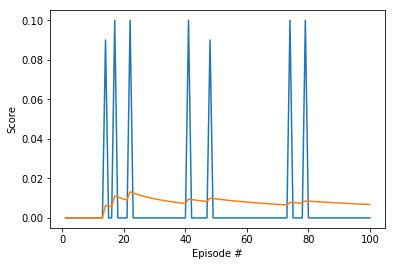

Episode 200, Average Score: 0.01, Current Score: 0.00, Noise Scaling: 1.00, Memory size: 3333 and Num Steps: 15

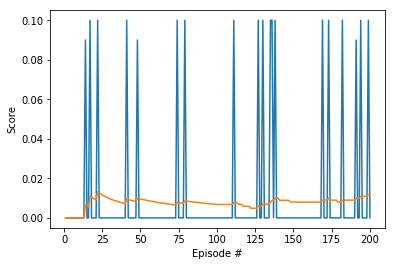

Episode 300, Average Score: 0.02, Current Score: 0.00, Noise Scaling: 1.00, Memory size: 5205 and Num Steps: 14

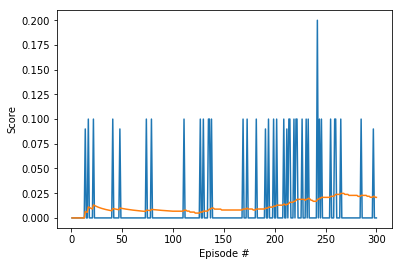

Episode 400, Average Score: 0.00, Current Score: 0.00, Noise Scaling: 0.90, Memory size: 6628 and Num Steps: 14

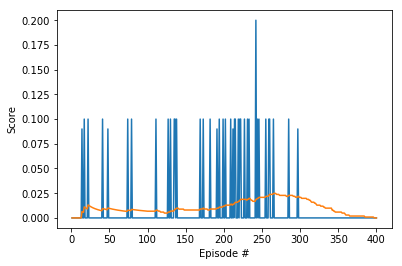

Episode 500, Average Score: 0.00, Current Score: 0.00, Noise Scaling: 0.82, Memory size: 8114 and Num Steps: 14

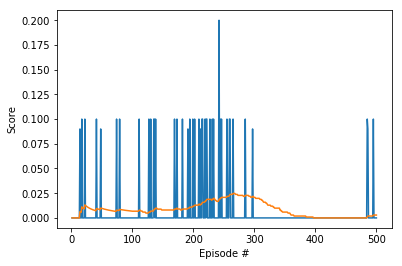

Episode 600, Average Score: 0.03, Current Score: 0.10, Noise Scaling: 0.74, Memory size: 10171 and Num Steps: 31

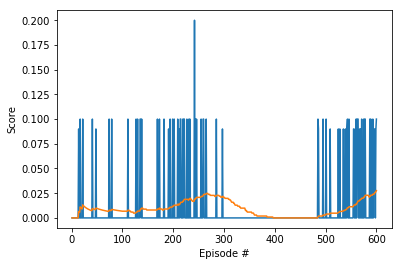

Episode 700, Average Score: 0.07, Current Score: 0.10, Noise Scaling: 0.67, Memory size: 13197 and Num Steps: 314

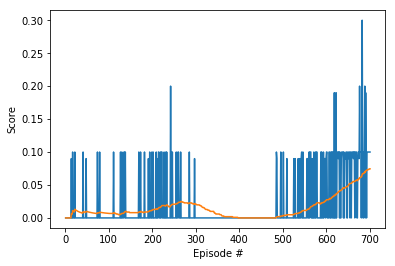

Episode 800, Average Score: 0.07, Current Score: 0.10, Noise Scaling: 0.61, Memory size: 16064 and Num Steps: 310

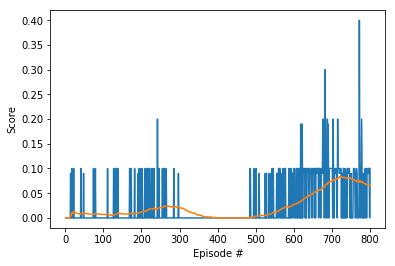

Episode 900, Average Score: 0.09, Current Score: 0.09, Noise Scaling: 0.55, Memory size: 19283 and Num Steps: 29

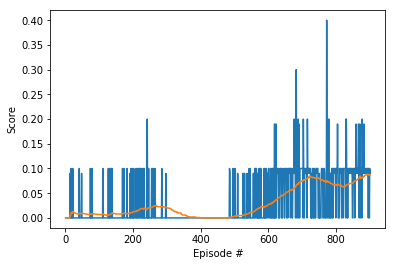

Episode 1000, Average Score: 0.11, Current Score: 0.20, Noise Scaling: 0.50, Memory size: 23222 and Num Steps: 72

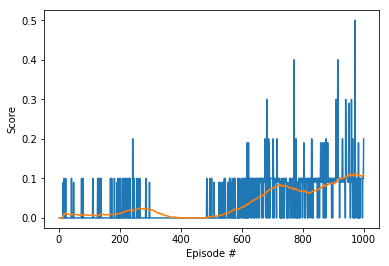

Episode 1100, Average Score: 0.10, Current Score: 0.10, Noise Scaling: 0.45, Memory size: 26760 and Num Steps: 304

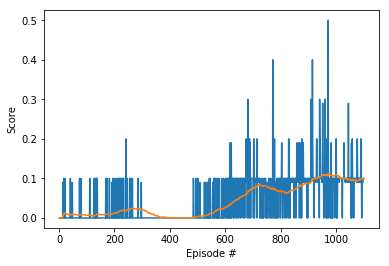

Episode 1200, Average Score: 0.10, Current Score: 0.10, Noise Scaling: 0.41, Memory size: 30585 and Num Steps: 308

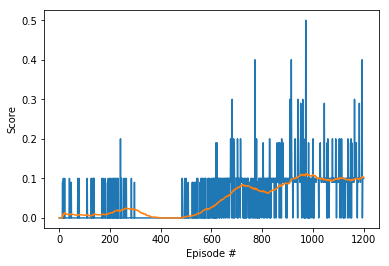

Episode 1300, Average Score: 0.13, Current Score: 0.00, Noise Scaling: 0.37, Memory size: 35854 and Num Steps: 149

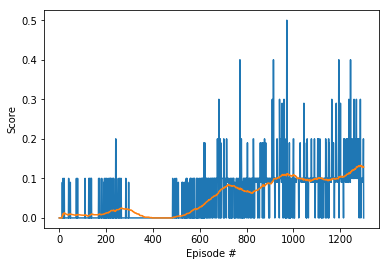

Episode 1400, Average Score: 0.12, Current Score: 0.10, Noise Scaling: 0.33, Memory size: 40756 and Num Steps: 558

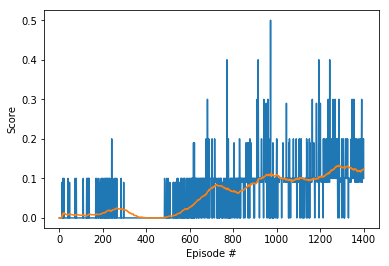

Episode 1500, Average Score: 0.23, Current Score: 0.19, Noise Scaling: 0.30, Memory size: 50154 and Num Steps: 508

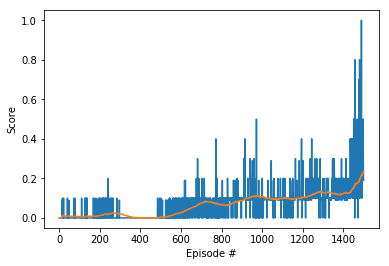

Episode 1571, Average Score: 0.52, Current Score: 2.30, Noise Scaling: 0.28, Memory size: 66705 and Num Steps: 907

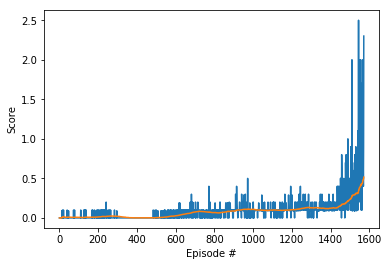

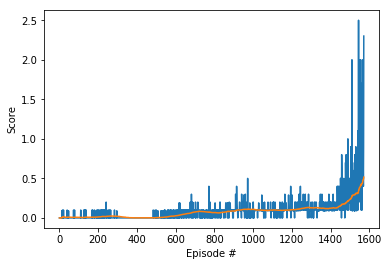

In [10]:
scores, scores_avg = MADDPG_Training()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()